# Данные

Получить из имеющихся 3D координат представление белка в виде графа. Базовая идея: матрица смежности + матрица признаков

Важно: в данных с CASP нет информации о ковалентных связях, нужно их получить

Some additional ideas:
* добавить веса на ребрах (например вместо {0,1} ставить значения расстояний между атомами)
* представление графа: Диаграмма Вороного

Данные взяты с сайта CASP 
>[CASP12](http://predictioncenter.org/casp12/index.cgi) $\to$ RESULTS $\to$ parsable data
* Реальные модели: targets/casp12.targets_T0.releaseDec022016.tgz
* Сгенерированные модели: server_predictions/T*.stage2.3D.srv.tar.gz

## Retrieve CAD-score

* Train dataset: сгенерированные модели белков + реальные соответствующие смоделированным белки. На основе их считаем CAD-score. X_train = сгенерированные модели белков, y_train = CAD-scores
* Test: CASP competition, выдается n смоделированных белков, предполагается, что они якобы из норм распределения, чтобы z-score вычислить. орги каждой модели присваивают Z-score того, насколько хороша модель(замена нашему CAD-score). Ранжируют модели по z-скору. участникам дается этот набор моделей, мы ранжируем/выбираем лучшую и орги оценивают по своему z-скору, насколько хорошую выбрали

Получим cad-scores для всех имеющихся моделей

Использовалась реализация подсчета cad-score из https://github.com/kliment-olechnovic/voronota

In [1]:
!bash 0_do_cadscore_script.bash

bash: 0_do_cadscore_script.bash: No such file or directory


Для каждого таргета записали в файл результаты cad-scores всех моделей в виде:

{target file path} {model file path} {query code} {number of residues} {global score} {target total area} {corresponding model total area}

global score и есть значение cad-score

## Загрузка и анализ данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import math
import time, datetime
import random
#import scipy.optimize as optim
#from tqdm.notebook import tqdm
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
mpl.style.use('seaborn')

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

plt.rc('font', size=15)
plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.figsize'] = (11.0, 7.0)

In [3]:
!pip install biopandas

     |████████████████████████████████| 266kB 2.8MB/s 


In [2]:
from biopandas.pdb import PandasPdb
from Bio.PDB import NeighborSearch, PDBParser
ppdb = PandasPdb()

### Пример данных

In [10]:
test_models_path = '../../data/CASP12/'
test_target_path = '../../data/CASP12/targets_T0_/'
test_targets = os.listdir(test_models_path)
test_target_names = sorted([s.replace('.pdb', '') for s in test_targets])[1:]

example = ppdb.read_pdb(test_target_path + test_target_names[14] + '.pdb')

data_df = ppdb.df['ATOM']
#print(data_df.dtypes)
data_df.head()

record_name  atom_number blank_1 atom_name alt_loc residue_name blank_2  \
0        ATOM            1                 N                  GLU           
1        ATOM            2                CA                  GLU           
2        ATOM            3                 C                  GLU           
3        ATOM            4                 O                  GLU           
4        ATOM            5                CB                  GLU           

  chain_id  residue_number insertion  ... x_coord  y_coord  z_coord  \
0                        4            ...  52.925  104.538  110.353   
1                        4            ...  53.031  104.481  108.900   
2                        4            ...  53.070  105.878  108.295   
3                        4            ...  52.802  106.870  108.972   
4                        4            ...  51.858  103.698  108.305   

   occupancy  b_factor  blank_4 segment_id element_symbol charge  line_idx  
0        1.0    102.11                                  N    NaN         6  
1        1.0     87.62                                  C    NaN         7  
2        1.0     88.82                                  C    NaN         8  
3        1.0     78.84                                  O    NaN         9  
4        1.0     82.76                                  C    NaN        10  

[5 rows x 21 columns]

In [11]:
residues = data_df.loc[:, ['residue_name']].values.tolist()
residue_names = set([i[0] for i in residues])
print(residue_names)

{'TRP', 'ILE', 'GLY', 'LYS', 'PRO', 'LEU', 'VAL', 'GLU', 'CYS', 'ASP', 'THR', 'PHE', 'ARG', 'MET', 'HIS', 'ASN', 'SER', 'TYR', 'GLN', 'ALA'}


[О типах аминокислот](https://www.sigmaaldrich.com/life-science/metabolomics/learning-center/amino-acid-reference-chart.html)

Дополнительно для вникания в данные http://www.imgt.org/IMGTeducation/Aide-memoire/_UK/aminoacids/formuleAA/#MLformula
<img src='https://i.imgur.com/g0Ydb2O.png' alt='aminos' width="600"/>



In [12]:
atoms = data_df.loc[:, ['atom_name']].values.tolist()
atom_names = set([i[0] for i in atoms])
print(atom_names)

{'HE', 'HA', 'CG1', 'HB2', 'OE2', 'NE1', 'HD2', 'HB1', 'HH2', 'OE1', 'HZ2', 'HE22', 'HG', 'HD12', 'C', 'SD', 'H', 'CH2', 'CD2', 'HB', 'CG2', 'NZ', 'HZ3', 'HZ', 'HD22', 'HG21', 'NE', 'ND1', 'HB3', 'HD13', 'HG11', 'CZ', 'N', 'HE21', 'CB', 'HE3', 'NE2', 'ND2', 'HD23', 'CZ3', 'HH12', 'HA2', 'HG12', 'HD1', 'OD1', 'HE1', 'NH2', 'OD2', 'HG1', 'OXT', 'HG13', 'CE3', 'HH', 'CD1', 'HG23', 'CD', 'OH', 'HH22', 'SG', 'HZ1', 'HG22', 'CE1', 'HG2', 'HA3', 'OG', 'OG1', 'CA', 'HH21', 'CE2', 'CZ2', 'HD21', 'HD3', 'CG', 'HG3', 'HH11', 'CE', 'HE2', 'O', 'HD11', 'NH1'}


In [13]:
elements = data_df.loc[:, ['element_symbol']].values.tolist()
elements_names = set([i[0] for i in elements])
print(elements_names)

{'H', 'S', 'N', 'O', 'C'}


## Матрица смежности

In [18]:
kMinDistanceBetweenAtoms = 0.01

# элементы периодической системы и соответствующие им радиусы
periodic_table = {
  'H': 1.2, 'He': 1.4, 'Li': 1.82, 'Be': 2.0,
  'B': 2.0, 'C': 1.7, 'N': 1.55, 'O': 1.52,
  'F': 1.47, 'Ne': 1.54, 'Na': 2.27, 'Mg': 1.73,
  'Al': 2.0, 'Si': 2.1, 'P': 1.9, 'S': 1.8,
  'Cl': 1.75, 'Ar': 1.88, 'K': 2.75, 'Ca': 1.2,
  'Sc': 2.0, 'Ti': 2.0, 'V': 2.0, 'Cr': 2.0,
  'Mn': 2.0, 'Fe': 2.0, 'Co': 2.0, 'Ni': 1.63,
  'Cu': 1.4, 'Zn': 1.39, 'Ga': 1.07, 'Ge': 2.0,
  'Aa': 1.85, 'Se': 1.9, 'Br': 1.85, 'Kr': 2.02,
  'Rb': 2.0, 'Sr': 2.0, 'Y': 2.0, 'Zr': 2.0,
  'Nb': 2.0, 'Mo': 2.0, 'Tc': 2.0, 'Ru': 2.0,
  'Rh': 2.0, 'Pd': 1.63, 'Ag': 1.72, 'Cd': 1.58,
  'In': 1.93, 'Sn': 2.17, 'Sb': 2.0, 'Te': 2.06,
  'I': 1.98, 'Xe': 2.16, 'Cs': 2.0, 'Ba': 2.0,
  'La': 2.0, 'Ce': 2.0, 'Pr': 2.0, 'Nd': 2.0,
  'Pm': 2.0, 'Sm': 2.0, 'Eu': 2.0, 'Gd': 2.0,
  'Tb': 2.0, 'Dy': 2.0, 'Ho': 2.0, 'Er': 2.0,
  'Tm': 2.0, 'Yb': 2.0, 'Lu': 2.0, 'Hf': 2.0,
  'Ta': 2.0, 'W': 2.0, 'Re': 2.0, 'Os': 2.0,
  'Ir': 2.0, 'Pt': 1.72, 'Au': 1.66, 'Hg': 1.55,
  'Tl': 1.96, 'Pb': 2.02, 'Bi': 2.0, 'Po': 2.0,
  'At': 2.0, 'Rn': 2.0, 'Fr': 2.0, 'Ra': 2.0,
  'Ac': 2.0, 'Th': 2.0, 'Pa': 2.0, 'U': 1.86,
  'Np': 2.0, 'Pu': 2.0, 'Am': 2.0, 'Cm': 2.0,
  'Bk': 2.0, 'Cf': 2.0, 'Es': 2.0, 'Fm': 2.0,
  'Md': 2.0, 'No': 2.0, 'Lr': 2.0, 'Rf': 2.0,
  'Db': 2.0, 'Sg': 2.0, 'Bh': 2.0, 'Hs': 2.0,
  'Mt': 2.0, 'Ds': 2.0, 'Rg': 2.0
}

# получает радиус элемента
def getElementRadius(atom):
    '''
    если поле 'element_symbol' не пусто, выведем радиус, 
    соответствующий элементу в periodic_table,
    иначе будет выводить просто максимальный радиус из periodic_table
    '''
    if atom['element_symbol'] != '':
        return periodic_table[atom['element_symbol']]
    else:
        return 2.0
    

# расстояние между атомами
def getDistance(atom1, atom2):
    x1, y1, z1 = atom1['x_coord'], atom1['y_coord'], atom1['z_coord']
    x2, y2, z2 = atom2['x_coord'], atom2['y_coord'], atom2['z_coord']
    
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    
    
# проверяет, есть ли соединение между атомами
def HaveCovalentBond(atom1, atom2):

    # не соединяем атомы, которые находятся далеко в последовательности
    if (abs(atom1['residue_number'] - atom2['residue_number']) > 1):
        return False
    
    distance = getDistance(atom1, atom2)

    # не соединяем водороды
    # если водород, то element_symbol H, а значит первый символ atom_name тоже H
    # не проверяем element_symbol, т.к. столбца может не быть в данных
    if ('H' in atom1['atom_name'][0] and 'H' in atom2['atom_name'][0]):
        return False

    if (('H' in atom1['atom_name'][0] or 'H' in atom2['atom_name'][0]) and distance >= 1.21):
        return False

    # не создаем SS-связи
    if ('SG' in atom1['atom_name'] and 'SG' in atom2['atom_name']):
        return False

    distanceMax = ((getElementRadius(atom1) + getElementRadius(atom2)) * 0.6) ** 2

    return distance <= distanceMax and distance > kMinDistanceBetweenAtoms

def AdjacencyMatrix(target_name, model_name):
    
    pdb_file_path = models_path + target_name + '/' + model_name
    #temp = ppdb.read_pdb(pdb_file_path)
    #protein = ppdb.df['ATOM']
    
    
    if not os.path.exists(models_path + target_name + '/adjacency'):
        os.mkdir(models_path + target_name + '/adjacency')
        
    f = open(models_path + target_name + '/adjacency/' + model_name + '_adj.txt', "w")
    
    parser = PDBParser(PERMISSIVE=True, QUIET=True)
    structure = parser.get_structure(model_name, pdb_file_path)
    atoms = [atom for atom in structure.get_atoms()]
    neighbors_searcher = NeighborSearch(atoms)
    SEARCH_RADIUS = 6
    pairs = neighbors_searcher.search_all(radius=SEARCH_RADIUS)
    covalent_bonds = []
    for atom_1, atom_2 in pairs:
        if HaveCovalentBond(atom_1, atom_2):
            print(atom_1)
            f.write(' ' + str(j))
                # возможно стоит записывать еще прочие признаки, как residue_number, distance, atom_name, residue_name
        f.write('\n')
    f.close()
    '''
    for i in range(protein.shape[0]):
        f.write('atom' + str(i))
        for j in range(protein.shape[0]):
            # т.к. матрица сильно разреженная, эффективнее записывать только 1
            if i != j and HaveCovalentBond(protein.loc[i], protein.loc[j]):
                #distance = getDistance(protein.loc[i], protein.loc[j])
                f.write(' ' + str(j))
                # возможно стоит записывать еще прочие признаки, как residue_number, distance, atom_name, residue_name
        f.write('\n')
    f.close()
    '''

In [59]:
tqdm._instances.clear()

### Total data statistics

In [84]:
models_paths = ['../../data/CASP7/models/', '../../data/CASP8/models/',
                '../../data/CASP9/models/', '../../data/CASP10/models/',
                '../../data/CASP11/models/','../../data/CASP12/models/']
targets_paths = ['../../data/CASP7/targets/','../../data/CASP8/targets/',
                 '../../data/CASP9/targets/', '../../data/CASP10/targets/',
                 '../../data/CASP11/targets/','../../data/CASP12/targets/']
competitions = ['CASP7', 'CASP8', 'CASP9', 'CASP10', 'CASP11', 'CASP12']

unwanted = {'.DS_Store', 'adjacency_old', 'adjacency'}

In [85]:
for i in range(len(competitions)):  
    targets = sorted(os.listdir(targets_paths[i]))
    targets = [target for target in targets if target not in unwanted]
    print(targets)

['T0283.pdb', 'T0285.pdb', 'T0286.pdb', 'T0288.pdb', 'T0289.pdb', 'T0290.pdb', 'T0291.pdb', 'T0292.pdb', 'T0293.pdb', 'T0295.pdb', 'T0296.pdb', 'T0297.pdb', 'T0298.pdb', 'T0299.pdb', 'T0300.pdb', 'T0301.pdb', 'T0302.pdb', 'T0303.pdb', 'T0304.pdb', 'T0305.pdb', 'T0306.pdb', 'T0307.pdb', 'T0308.pdb', 'T0309.pdb', 'T0310.pdb', 'T0311.pdb', 'T0312.pdb', 'T0313.pdb', 'T0314.pdb', 'T0315.pdb', 'T0316.pdb', 'T0317.pdb', 'T0318.pdb', 'T0319.pdb', 'T0320.pdb', 'T0321.pdb', 'T0322.pdb', 'T0323.pdb', 'T0324.pdb', 'T0325.pdb', 'T0326.pdb', 'T0327.pdb', 'T0328.pdb', 'T0329.pdb', 'T0330.pdb', 'T0331.pdb', 'T0332.pdb', 'T0333.pdb', 'T0334.pdb', 'T0335.pdb', 'T0338.pdb', 'T0339.pdb', 'T0340.pdb', 'T0341.pdb', 'T0342.pdb', 'T0343.pdb', 'T0345.pdb', 'T0346.pdb', 'T0347.pdb', 'T0348.pdb', 'T0349.pdb', 'T0350.pdb', 'T0351.pdb', 'T0353.pdb', 'T0354.pdb', 'T0356.pdb', 'T0357.pdb', 'T0358.pdb', 'T0359.pdb', 'T0360.pdb', 'T0361.pdb', 'T0362.pdb', 'T0363.pdb', 'T0364.pdb', 'T0365.pdb', 'T0366.pdb', 'T0367.pdb'

In [91]:
TOTAL_TARGETS = 0
TOTAL_MODELS = 0
for i, comp in enumerate(competitions):
    print('TOTAL FOR {}'.format(comp))
    targets = sorted(os.listdir(targets_paths[i]))
    targets = [target for target in targets if target not in unwanted]
    models_count = 0
    for target_name in targets:
        models = sorted(os.listdir(models_paths[i] + target_name[:-4]))
        models = [model for model in models if model not in unwanted]
        models_count += len(models)
    print('Targets: {}'.format(len(targets)))
    print('Models: {}'.format(models_count))
    TOTAL_TARGETS += len(targets)
    TOTAL_MODELS += models_count
    print('-'*40)
print('TOTAL TARGETS: {}\nTOTAL MODELS: {}'.format(TOTAL_TARGETS, TOTAL_MODELS))

TOTAL FOR CASP7
Targets: 95
Models: 24183
----------------------------------------
TOTAL FOR CASP8
Targets: 123
Models: 36176
----------------------------------------
TOTAL FOR CASP9
Targets: 117
Models: 35963
----------------------------------------
TOTAL FOR CASP10
Targets: 103
Models: 15450
----------------------------------------
TOTAL FOR CASP11
Targets: 84
Models: 12291
----------------------------------------
TOTAL FOR CASP12
Targets: 37
Models: 5538
----------------------------------------
TOTAL TARGETS: 559
TOTAL MODELS: 129601


In [0]:
targets2 = sorted(target_names)[1:5]
for i, target_name in enumerate(targets2):
    print('Target [{}/{}]\n{} started at {}'.format(i+1, len(targets2), 
                                                    target_name, datetime.datetime.now().time()))
    models = sorted(os.listdir(models_path + target_name))
    for model in tqdm(random.sample((models), 25)):
        AdjacencyMatrix(target_name, model)

Target [1/4]
T0860 started at 08:11:27.271152



Target [2/4]
T0861 started at 11:35:23.925630


In [15]:
targets5 = sorted(target_names)[7:8]
for i, target_name in enumerate(targets5):
    print('Target [{}/{}]\n{} started at {}'.format(i+1, len(targets5), 
                                                    target_name, datetime.datetime.now().time()))
    models = sorted(os.listdir(models_path + target_name))
    for model in tqdm(random.sample((models), 25)):
        #print(model)
        AdjacencyMatrix(target_name, model)

Target [1/1]
T0866 started at 19:33:27.917192


## Визуализация

https://pygsp.readthedocs.io/en/stable/reference/graphs.html

In [3]:
from pygsp import graphs, filters, plotting

In [23]:
adj_path = '../../data/CASP12/' + test_target_names[10]+ '/adjacency/'
adj_for_test = sorted(os.listdir(adj_path))[1:]

filepath = adj_path + adj_for_test[4]
print(filepath)

../../data/CASP12/T0870/adjacency/BAKER-ROSETTASERVER_TS3_adj.txt


In [374]:
'../../data/CASP12/' + target_names[10] + '/'+ adj_for_test[4][:-8]

'../../data/CASP12/T0870/BAKER-ROSETTASERVER_TS3'

In [24]:
ttt = ppdb.read_pdb('../../data/CASP12/' + test_target_names[10] + '/'+ adj_for_test[4][:-8])
temp_model = ppdb.df['ATOM']
temp_model.iloc[-1][1]
#pompom = temp_model[['atom_number','x_coord', 'y_coord', 'z_coord']]
#coords.loc[coords['atom_number']==int(t.split('_')[0])].values[0][1]

2177

In [25]:
%%time
with open(filepath) as fp:
    ttt = ppdb.read_pdb('../../data/CASP12/' + test_target_names[10] + '/'+ adj_for_test[4][:-8])
    temp_model = ppdb.df['ATOM']
    protein_size = temp_model.shape[0]
    print(temp_model.shape[0])
    adjacency = np.zeros((protein_size, protein_size))
    coords = temp_model[['x_coord', 'y_coord', 'z_coord']].values
    
    Xe=[]
    Ye=[]
    Ze=[]

    line = fp.readline()
    while line:
        for t in line.strip().split(' '):
            adjacency[int(t.split('_')[0])][int(t.split('_')[1])] = 1
            adjacency[int(t.split('_')[1])][int(t.split('_')[0])] = 1
            Xe+=[coords[int(t.split('_')[0])][0], coords[int(t.split('_')[1])][0], None] # x-coordinates of edge ends
            Ye+=[coords[int(t.split('_')[0])][1], coords[int(t.split('_')[1])][1], None]
            Ze+=[coords[int(t.split('_')[0])][2], coords[int(t.split('_')[1])][2], None]
            
            '''
            Xe+=[coords.loc[coords['atom_number']==int(t.split('_')[0])].values[0][1],
                 coords.loc[coords['atom_number']==int(t.split('_')[1])].values[0][1], None]
            Ye+=[coords.loc[coords['atom_number']==int(t.split('_')[0])].values[0][2],
                 coords.loc[coords['atom_number']==int(t.split('_')[1])].values[0][2], None]
            Ze+=[coords.loc[coords['atom_number']==int(t.split('_')[0])].values[0][3], 
                 coords.loc[coords['atom_number']==int(t.split('_')[1])].values[0][3], None]
            '''
        line = fp.readline()

print(adjacency)

1068
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
CPU times: user 134 ms, sys: 13.3 ms, total: 148 ms
Wall time: 152 ms


In [28]:
x, y, z = coords[:,0], coords[:,1], coords[:,2]

trace1 = go.Scatter3d(x=x, y=y, z=z,
                      mode='markers',
                      marker=dict(
                          size=2.5,
                          color='darkblue',
                          opacity=0.9)
                     )

trace2 = go.Scatter3d(x=Xe, y=Ye, z=Ze,
                      mode='lines',
                      line=dict(color='rgb(125,125,125)', width=1.1),
                      hoverinfo='none'
                     )

axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=True,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title=test_target_names[10] + ' ' + adj_for_test[4][:-8],
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
         ),
         margin=dict(t=100),
         hovermode='closest')

data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

#py.iplot(fig, filename='Protein')

iplot(fig)

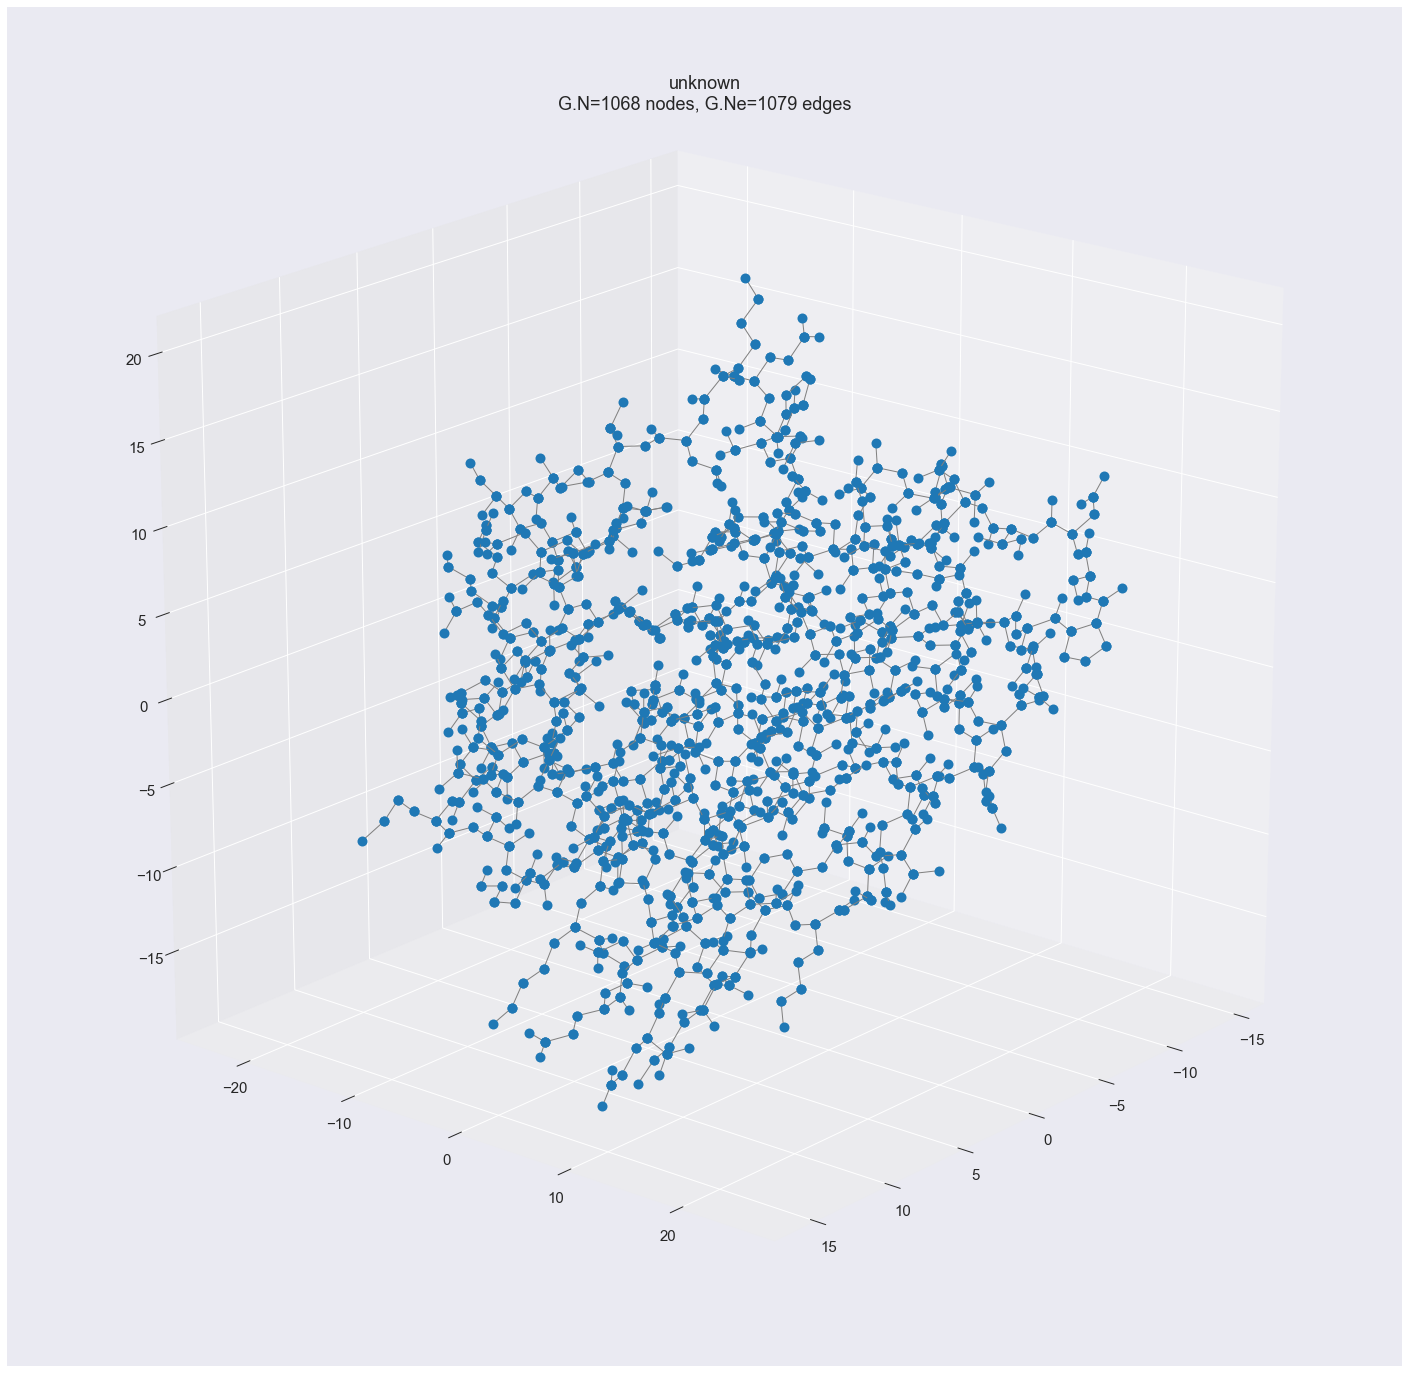

In [29]:
G = graphs.Graph(W=adjacency, coords=coords)
fig = plt.figure(figsize=(25, 25))
ax = plt.axes(projection='3d')
G.plot(ax=ax)
ax.view_init(20, 40)
plt.savefig('./example_graph.png')

In [354]:
with open(filepath) as fp:
    ttt = ppdb.read_pdb('../../data/CASP12/' + target_names[0] + '/'+ adj_for_test[4][:-8])
    temp_model = ppdb.df['ATOM']
    protein_size = temp_model.shape[0]
    print(protein_size)
    adjacency = np.zeros((protein_size, protein_size))
    coords = temp_model[['x_coord', 'y_coord', 'z_coord']].values
    
    Xe=[]
    Ye=[]
    Ze=[]

    line = fp.readline()
    while line:
        list_temp = line.strip().split(' ')
        atom_number = int(list_temp[0][4:]) # atomXXX
        connections = list(map(int, list_temp[1:]))
        adjacency[atom_number][connections] = 1
        
        for vertex in connections:
            Xe+=[coords[atom_number][0], coords[vertex][0], None] # x-coordinates of edge ends
            Ye+=[coords[atom_number][1], coords[vertex][1], None]
            Ze+=[coords[atom_number][2], coords[vertex][2], None]
    
        line = fp.readline()

print(adjacency)

972


ValueError: invalid literal for int() with base 10: '_3628'

https://plotly.com/python/v3/3d-network-graph/

In [19]:
x, y, z = coords[:,0], coords[:,1], coords[:,2]

trace1 = go.Scatter3d(x=x, y=y, z=z,
                      mode='markers',
                      marker=dict(
                          size=2.5,
                          color='darkblue',
                          opacity=0.9)
                     )

trace2 = go.Scatter3d(x=Xe, y=Ye, z=Ze,
                      mode='lines',
                      line=dict(color='rgb(125,125,125)', width=0.6),
                      hoverinfo='none'
                     )

axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=True,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title=target_names[0] + ' ' + adj_for_test[4][:-8],
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
         ),
         margin=dict(t=100),
         hovermode='closest')

data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

#py.iplot(fig, filename='Protein')

iplot(fig)

## Попарные расстояния

In [30]:
from scipy.spatial import distance_matrix

In [31]:
array_x = np.array(coords)
array_y = np.array(coords)

distance_mtrx = distance_matrix(array_x, array_y)

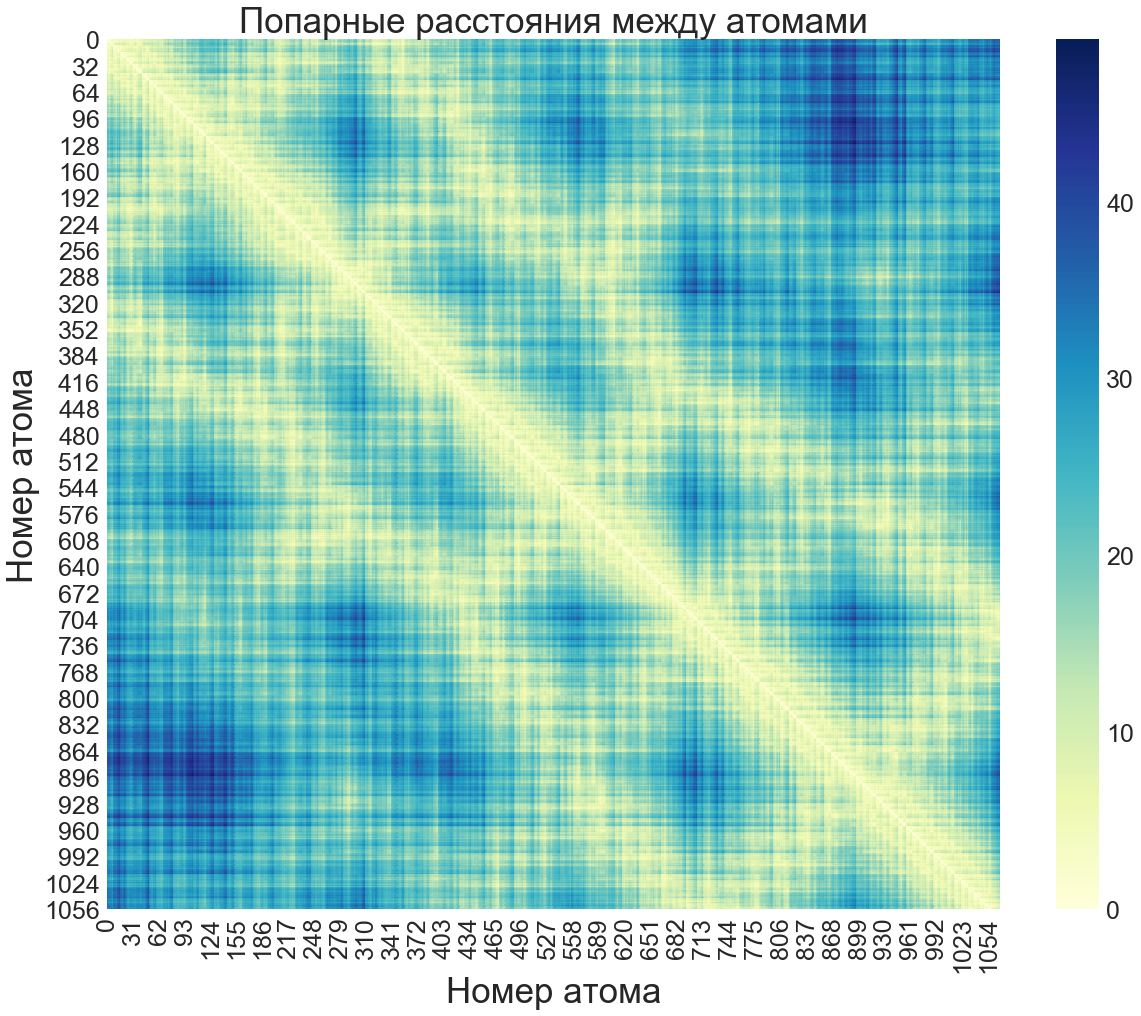

In [52]:
plt.figure(figsize =(20,16))
ax = sns.heatmap(distance_mtrx, cmap="YlGnBu")
plt.title('Попарные расстояния между атомами', fontsize = 35)
plt.xlabel('Номер атома', fontsize = 35)
plt.ylabel('Номер атома', fontsize = 35)
plt.show()
ax.figure.savefig("pairwise.png")

In [358]:
distanceMax = ((2.0 + 2.0) * 0.6) ** 2
print('Максимальное расстояние между атомами, которые могут быть соединены {}'.format(distanceMax))

Максимальное расстояние между атомами, которые могут быть соединены 5.76


По рисунку видно, что могут иметь соединения атомы, обозначенные на рисунке самым светлым желтым. Т.е. матрица смежности будет сильно разреженной

## Сохранение в датасет

X – coordinates

A – adjacency matrices

y – cad-scores

#### y_train + y_test

In [359]:
cad_path = '../cad_results/'
targets = sorted(os.listdir(cad_path))[1:]

In [360]:
cad_scores_dict = dict()
#cad_scores = list()
for target in targets[:8]:
    filepath = cad_path + target
    with open(filepath) as fp:
        line = fp.readline()
        while line:
            list_temp = line.strip().split(' ')
            target = list_temp[0][24:-4]
            model = list_temp[1][24:]
            cad = float(list_temp[4])
            #cad_scores.append((target, model, cad))
            cad_scores_dict.update({(target, model): cad})
            line = fp.readline()

In [361]:
cad_scores_dict[(target, model)]

0.25839

**DATA format: {target_name}, {model_name}, {coordinates}, {adjacency_matrix}, {cad-score}**

In [92]:
DATA = list()
unwanted = {'.DS_Store', 'adjacency', 'adjacency_old'}

for target in targets:
    target = target[:-11]
    adj_path = '../../data/CASP12/' + target + '/adjacency/'
    models_path = '../../data/CASP12/' + target
    
    # смотрим только те, к которым посчитаны матрицы смежности
    models = sorted(os.listdir(adj_path))
    #models.remove('.DS_Store')
    #models = sorted(os.listdir(models_path))
    models = [model for model in models if model not in unwanted]
    for model in tqdm(models):
        temp = ppdb.read_pdb(models_path + '/'+ model[:-8])
        temp_model = ppdb.df['ATOM']
        protein_size = temp_model.shape[0]
        coords = temp_model[['x_coord', 'y_coord', 'z_coord']].values
        cad = cad_scores_dict[(target, model[:-8])]
        adjacency = np.zeros((protein_size, protein_size))
        with open(adj_path + model) as fp:
            line = fp.readline()
            while line:
                for t in line.strip().split(' '):
                    adjacency[int(t.split('_')[0])][int(t.split('_')[1])] = 1
                    adjacency[int(t.split('_')[1])][int(t.split('_')[0])] = 1
                line = fp.readline()
            #while line:
            #    list_temp = line.strip().split(' ')
            #    atom_number = int(list_temp[0][4:]) # atomXXX
            #    connections = list(map(int, list_temp[1:]))
            #    adjacency[atom_number][connections] = 1
            #    line = fp.readline()
        
        DATA.append([target, model[:-8], coords, adjacency, cad]) # model = <name>_adj.txt

FileNotFoundError: [Errno 2] No such file or directory: '../../data/CASP12//adjacency/'

In [25]:
DATA = list()
unwanted = {'.DS_Store', 'adjacency', 'adjacency_old'}

for target in targets:
    target = target[:-11]
    adj_path = '../../data/CASP12/' + target + '/adjacency/'
    models_path = '../../data/CASP12/' + target
    
    # смотрим только те, к которым посчитаны матрицы смежности
    models = sorted(os.listdir(adj_path))
    #models.remove('.DS_Store')
    #models = sorted(os.listdir(models_path))
    models = [model for model in models if model not in unwanted]
    for model in tqdm(models):
        temp = ppdb.read_pdb(models_path + '/'+ model[:-8])
        temp_model = ppdb.df['ATOM']
        protein_size = temp_model.shape[0]
        coords = temp_model[['x_coord', 'y_coord', 'z_coord']].values
        cad = cad_scores_dict[(target, model[:-8])]
        adjacency = np.zeros((protein_size, protein_size))
        with open(adj_path + model) as fp:
            line = fp.readline()
            while line:
                for t in line.strip().split(' '):
                    adjacency[int(t.split('_')[0])][int(t.split('_')[1])] = 1
                    adjacency[int(t.split('_')[1])][int(t.split('_')[0])] = 1
            
            #while line:
            #    list_temp = line.strip().split(' ')
            #    atom_number = int(list_temp[0][4:]) # atomXXX
            #    connections = list(map(int, list_temp[1:]))
            #    adjacency[atom_number][connections] = 1
            #    line = fp.readline()
        
        DATA.append([target, model[:-8], coords, adjacency, cad]) # model = <name>_adj.txt

100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


In [26]:
len(DATA)

214

In [35]:
%%time
np.save('./data.npy', DATA)

CPU times: user 2.05 s, sys: 6.33 s, total: 8.38 s
Wall time: 15.6 s


In [8]:

with open('../cad_results/CASP11/T0770_cad_scores') as fp:
    count = 0
    line = fp.readline()
    while line:
        count +=1
        line = fp.readline()
    print(count)

58
